# **Experiment Notebook**



## Context


### 0. Import Packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

### 1.   Load Dataset

In [6]:
train_file_url = '../data/raw/train.csv'
test_file_url = '../data/raw/test.csv'

In [7]:
train_df = pd.read_csv(train_file_url)
test_df = pd.read_csv(test_file_url)

# df = pd.concat([train_df, test_df], ignore_index=True)
df =train_df

/var/folders/qz/l2xk6fnn5p399gdvg2snh00c0000gn/T/ipykernel_11149/2892945293.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_file_url)


### 2. Explore Dataset

In [8]:
pd.set_option('display.max_columns', None)
df.head()

,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,type,Rec_Rank,ast_tov,rimmade,rimmade_rimmiss,midmade,midmade_midmiss,rim_ratio,mid_ratio,dunksmade,dunksmiss_dunksmade,dunks_ratio,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,player_id,drafted
0,South Alabama,SB,26,29.5,97.3,16.6,42.5,44.43,1.6,4.6,15.8,16.3,10,14,0.714,26,68,0.382,13,39,0.333,0.3,1.5,13.1,So,2-Jun,NaN,0.258086,89.3938,2.5,2009,all,NaN,1.823646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.321,108.527,0.893017,49.9644,-4.995140,-1.623360,-3.371780,-4.723150,14.5769,-2.781990,-1.941150,0.1923,0.6154,0.8077,1.1923,0.3462,0.0385,3.8846,b2716b2d-3422-4959-9fe7-fe496414a4e8,0.0
1,Utah St.,WAC,34,60.9,108.3,14.9,52.4,54.48,3.8,6.3,13.6,19.8,30,45,0.667,56,113,0.496,20,51,0.392,1.0,1.1,27.4,So,4-Jun,NaN,1.334920,100.0660,3.4,2009,all,NaN,1.631621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.078,104.017,1.880030,111.9290,0.593024,1.385490,-0.792469,-0.300196,24.5294,-0.052263,-0.247934,0.6765,1.2647,1.9412,1.8235,0.4118,0.2353,5.9412,bb387960-e3a0-4ffd-96ae-184bad07cb8a,0.0
2,South Florida,BE,27,72.0,96.2,21.8,45.7,47.98,2.1,8.0,14.7,15.9,45,67,0.672,67,157,0.427,50,154,0.325,0.0,0.9,21.5,Sr,4-Jun,NaN,2.274070,104.1070,1.7,2009,all,NaN,1.081662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.556,102.154,2.763870,115.0210,0.003161,1.024770,-1.021610,0.665065,33.1852,1.548230,-0.883163,0.6296,2.3333,2.9630,1.9630,0.4815,0.0000,12.1852,89bbdf11-eadd-4de4-95e5-03f7e2874aa1,0.0
3,Pepperdine,WCC,30,44.5,97.7,16.0,53.6,53.69,4.1,9.4,13.7,23.8,14,27,0.519,25,63,0.397,28,62,0.452,0.8,1.9,21.6,Sr,4-Jun,NaN,0.552857,93.2086,2.0,2009,all,NaN,0.942830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.858,106.556,1.218710,84.1698,-0.977798,-0.502574,-0.475224,-0.736233,17.9667,-0.342775,-0.393459,0.7000,1.4333,2.1333,1.1000,0.5667,0.1333,4.9333,0c87ada8-8446-4ea2-a05b-bd07aed5f37a,0.0
4,Pacific,BW,33,56.2,96.5,22.0,52.8,54.31,8.3,18.6,8.2,22.7,64,114,0.561,93,176,0.528,0,0,0.000,1.9,1.3,64.8,Sr,8-Jun,NaN,1.060130,97.8554,3.8,2009,all,NaN,0.491229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.052,100.724,1.992790,128.0280,-1.836060,-1.946040,0.109983,-2.353180,22.9091,-1.684860,-0.668318,1.4242,3.3030,4.7273,0.8485,0.4545,0.3333,7.5758,84661e00-ad20-4308-817e-efa8da52a86c,0.0


In [9]:
df.shape

(46618, 64)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46618 entries, 0 to 46617
Data columns (total 64 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team                 46618 non-null  object 
 1   conf                 46618 non-null  object 
 2   GP                   46618 non-null  int64  
 3   Min_per              46618 non-null  float64
 4   Ortg                 46618 non-null  float64
 5   usg                  46618 non-null  float64
 6   eFG                  46618 non-null  float64
 7   TS_per               46618 non-null  float64
 8   ORB_per              46618 non-null  float64
 9   DRB_per              46618 non-null  float64
 10  AST_per              46618 non-null  float64
 11  TO_per               46618 non-null  float64
 12  FTM                  46618 non-null  int64  
 13  FTA                  46618 non-null  int64  
 14  FT_per               46618 non-null  float64
 15  twoPM                46618 non-null 

In [11]:
df.describe(include='all')

,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,type,Rec_Rank,ast_tov,rimmade,rimmade_rimmiss,midmade,midmade_midmiss,rim_ratio,mid_ratio,dunksmade,dunksmiss_dunksmade,dunks_ratio,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,player_id,drafted
count,46618,46618,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46618.000000,46326,46554,41939.0,46618.000000,46618.000000,46618.000000,46618.000000,46618,14337.000000,43151.000000,40860.000000,40860.000000,40860.000000,40860.000000,38119.000000,38050.000000,40860.000000,40860.000000,20400.000000,1207.000000,46576.000000,46576.000000,46576.000000,46576.000000,46576.000000,46576.000000,46576.000000,46576.000000,46582.000000,46576.000000,46576.000000,46582.000000,46582.000000,46582.000000,46582.000000,46582.000000,46582.000000,46582.000000,46618,46618.000000
unique,355,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,38,80.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20377,NaN
top,Army,A10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jr,7-Jun,1.0,NaN,NaN,NaN,NaN,all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2336a719-c648-440c-821d-32fb0d9760bf,NaN
freq,176,1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12401,4615,1743.0,NaN,NaN,NaN,NaN,46618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
mean,NaN,NaN,23.542988,37.339013,91.784360,18.164578,44.424392,47.571397,5.654071,12.575102,10.923008,20.535915,33.357909,47.887597,0.579193,41.521408,85.960444,0.424809,15.379274,44.595264,0.224779,1.877063,1.731048,38.111972,NaN,NaN,NaN,0.779567,89.277666,4.278710,2013.528036,NaN,53.217744,0.922210,27.779809,46.572614,14.853377,41.602619,0.562907,0.322901,3.774498,4.230470,0.866099,33.235294,103.364709,103.513641,1.427313,82.521563,-2.518313,-1.900248,-0.618064,-2.552051,16.949385,-2.088273,-0.463778,0.778630,1.867124,2.645755,1.066943,0.527743,0.283606,5.732429,NaN,0.009524
std,NaN,NaN,10.076829,28.019801,30.235568,6.181982,18.026404,17.217909,9.985025,11.041089,9.430012,12.210669,37.306108,50.190318,0.266445,43.820264,85.556152,0.191180,21.482081,57.557171,0.191479,6.271323,2.148502,36.821462,NaN,NaN,NaN,1.340548,30.669615,4.819912,2.873213,NaN,27.821187,0.691221,29.893780,47.108673,17.834037,45.221695,0.191550,0.170364,7.884873,8.631777,0.229589,16.624054,10.569908,11.405002,1.057080,65.092602,7.701851,5.186198,4.415293,8.305566,10.633054,6.160620,3.303826,0.745045,1.464894,2.096319,1.170469,0.469654,0.422755,4.942544,NaN,0.097127
min,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,-6.792410,-39.021300,0.000000,2009.000000,NaN,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1330.060000,-1292.020000,-0.857238,0.043033,-88.479400,-92.593500,-57.459400,-242.523000,0.000000,-141.539000,-100.984000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,NaN,NaN,17.000000,9.600000,83.900000,14.600000,40.000000,43.770000,1.900000,8.400000,4.600000,14.900000,4.000000,7.000000,0.500000,5.000000,13.000000,0.371000,0.000000,1.000000,0.000000,0.000000,0.900000,20.000000,NaN,NaN,NaN,-0.1737

In [12]:
# Assuming df is your DataFrame
nan_counts = df.isnull().sum()

# Filter to show only columns with NaN values
columns_with_nans = nan_counts[nan_counts > 0]

# Print the result
print(columns_with_nans)

yr                       292
ht                        64
num                     4679
Rec_Rank               32281
ast_tov                 3467
rimmade                 5758
rimmade_rimmiss         5758
midmade                 5758
midmade_midmiss         5758
rim_ratio               8499
mid_ratio               8568
dunksmade               5758
dunksmiss_dunksmade     5758
dunks_ratio            26218
pick                   45411
drtg                      42
adrtg                     42
dporpag                   42
stops                     42
bpm                       42
obpm                      42
dbpm                      42
gbpm                      42
mp                        36
ogbpm                     42
dgbpm                     42
oreb                      36
dreb                      36
treb                      36
ast                       36
stl                       36
blk                       36
pts                       36
dtype: int64


In [134]:
df.columns

Index(['team', 'conf', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per',
       'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per',
       'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per', 'blk_per',
       'stl_per', 'ftr', 'yr', 'ht', 'num', 'porpag', 'adjoe', 'pfr', 'year',
       'type', 'Rec_Rank', 'ast_tov', 'rimmade', 'rimmade_rimmiss', 'midmade',
       'midmade_midmiss', 'rim_ratio', 'mid_ratio', 'dunksmade',
       'dunksmiss_dunksmade', 'dunks_ratio', 'pick', 'drtg', 'adrtg',
       'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm',
       'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts',
       'player_id', 'drafted'],
      dtype='object')

### 3. Explore Target variable

In [135]:
target = 'drafted'

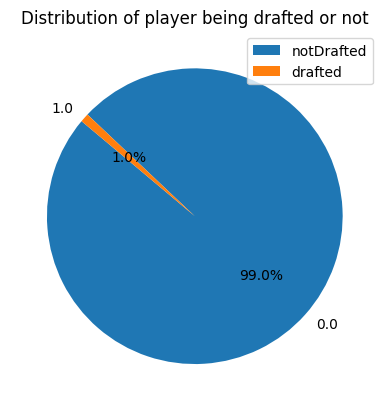

In [136]:
draftCount = df.drafted.value_counts().reset_index()
plt.pie(draftCount['count'], labels=draftCount['drafted'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of player being drafted or not')
plt.legend(labels=['notDrafted', 'drafted'])
plt.show()

The data here is imbalanced showing the majority of the college students not being selected as a NBA player. Out of total college student who are trying to get into NBA only 1% of them make it to the team.

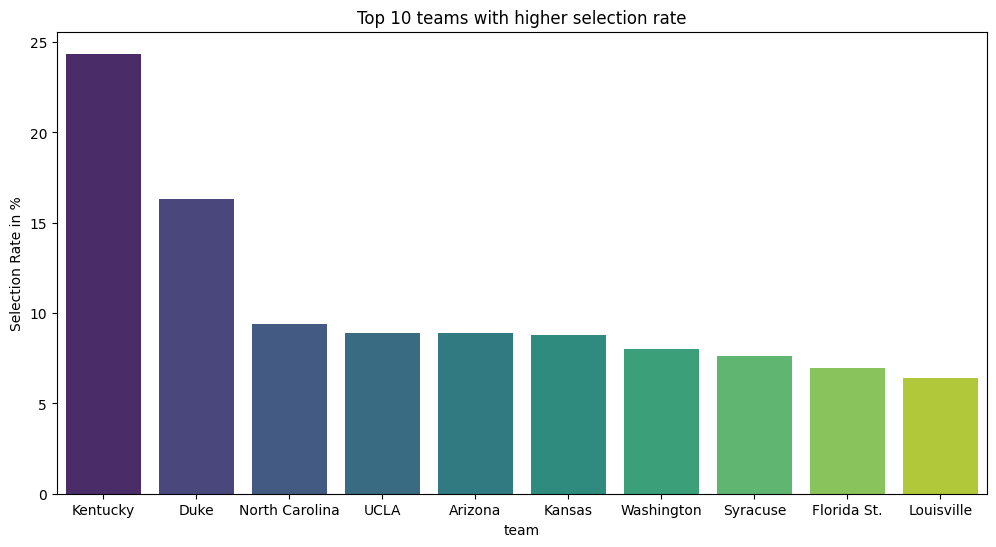

In [137]:
teamSelectionRate = df.groupby('team')['drafted'].mean() * 100
selectingTeam = teamSelectionRate.sort_values(ascending=False).reset_index()
selectingTeam.columns = ['team', 'selectionRate']
top5SelectingTeam = selectingTeam.head(10)

plt.figure(figsize=(12,6))
sns.barplot(top5SelectingTeam, x='team', y='selectionRate', palette='viridis', hue='team')
plt.ylabel('Selection Rate in %')
plt.title('Top 10 teams with higher selection rate')
plt.show()

Here, we can observe that the Kentucky team are one of those which have higher selection rate with about 24% into their team followed by Duke, North Carolina, UCLA and Arizona

In [138]:
np.sum([teamSelectionRate.values == 0])

np.int64(225)

In [139]:
teamSelectionRate[teamSelectionRate.values == 0]

team
Abilene Christian    0.0
Air Force            0.0
Akron                0.0
Alabama A&M          0.0
Alabama St.          0.0
                    ... 
Winston Salem St.    0.0
Winthrop             0.0
Wofford              0.0
Wright St.           0.0
Youngstown St.       0.0
Name: drafted, Length: 225, dtype: float64

So, according to this data some of the team doesn't even select the players and has 100% rejection rate

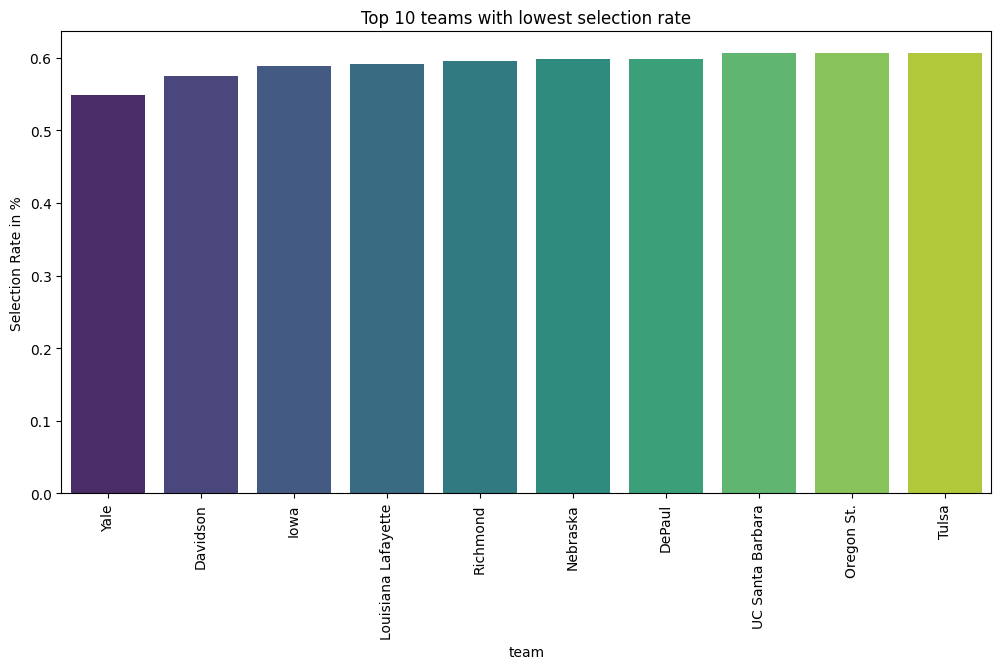

In [140]:
leastSelectionRateTeam = teamSelectionRate[teamSelectionRate.values > 0]
leastSelectingTeam = leastSelectionRateTeam.sort_values(ascending=True).reset_index()
leastSelectingTeam.columns = ['team', 'selectionRate']
least10SelectingTeam = leastSelectingTeam.head(10)

plt.figure(figsize=(12,6))
sns.barplot(least10SelectingTeam, x='team', y='selectionRate', palette='viridis', hue='team')
plt.ylabel('Selection Rate in %')
plt.title('Top 10 teams with lowest selection rate')
plt.xticks(rotation=90)
plt.show()

Some of the team with lowest selection rate rate are shown in the figure above with Yale being least among all the team that drafting players.

### 4. Explore Variables of Interest

/var/folders/qz/l2xk6fnn5p399gdvg2snh00c0000gn/T/ipykernel_1279/3920798700.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(df['conf'],palette = 'Set1')


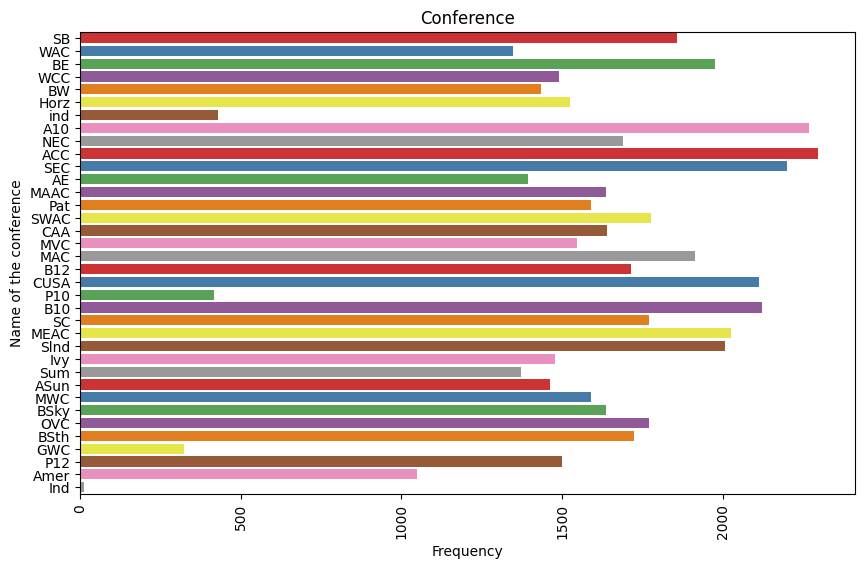

In [141]:
plt.figure(figsize=(10,6))
chart = sns.countplot(df['conf'],palette = 'Set1')
plt.title('Conference')
plt.xlabel('Frequency')
plt.ylabel('Name of the conference')
plt.xticks(rotation = 90)
plt.show()

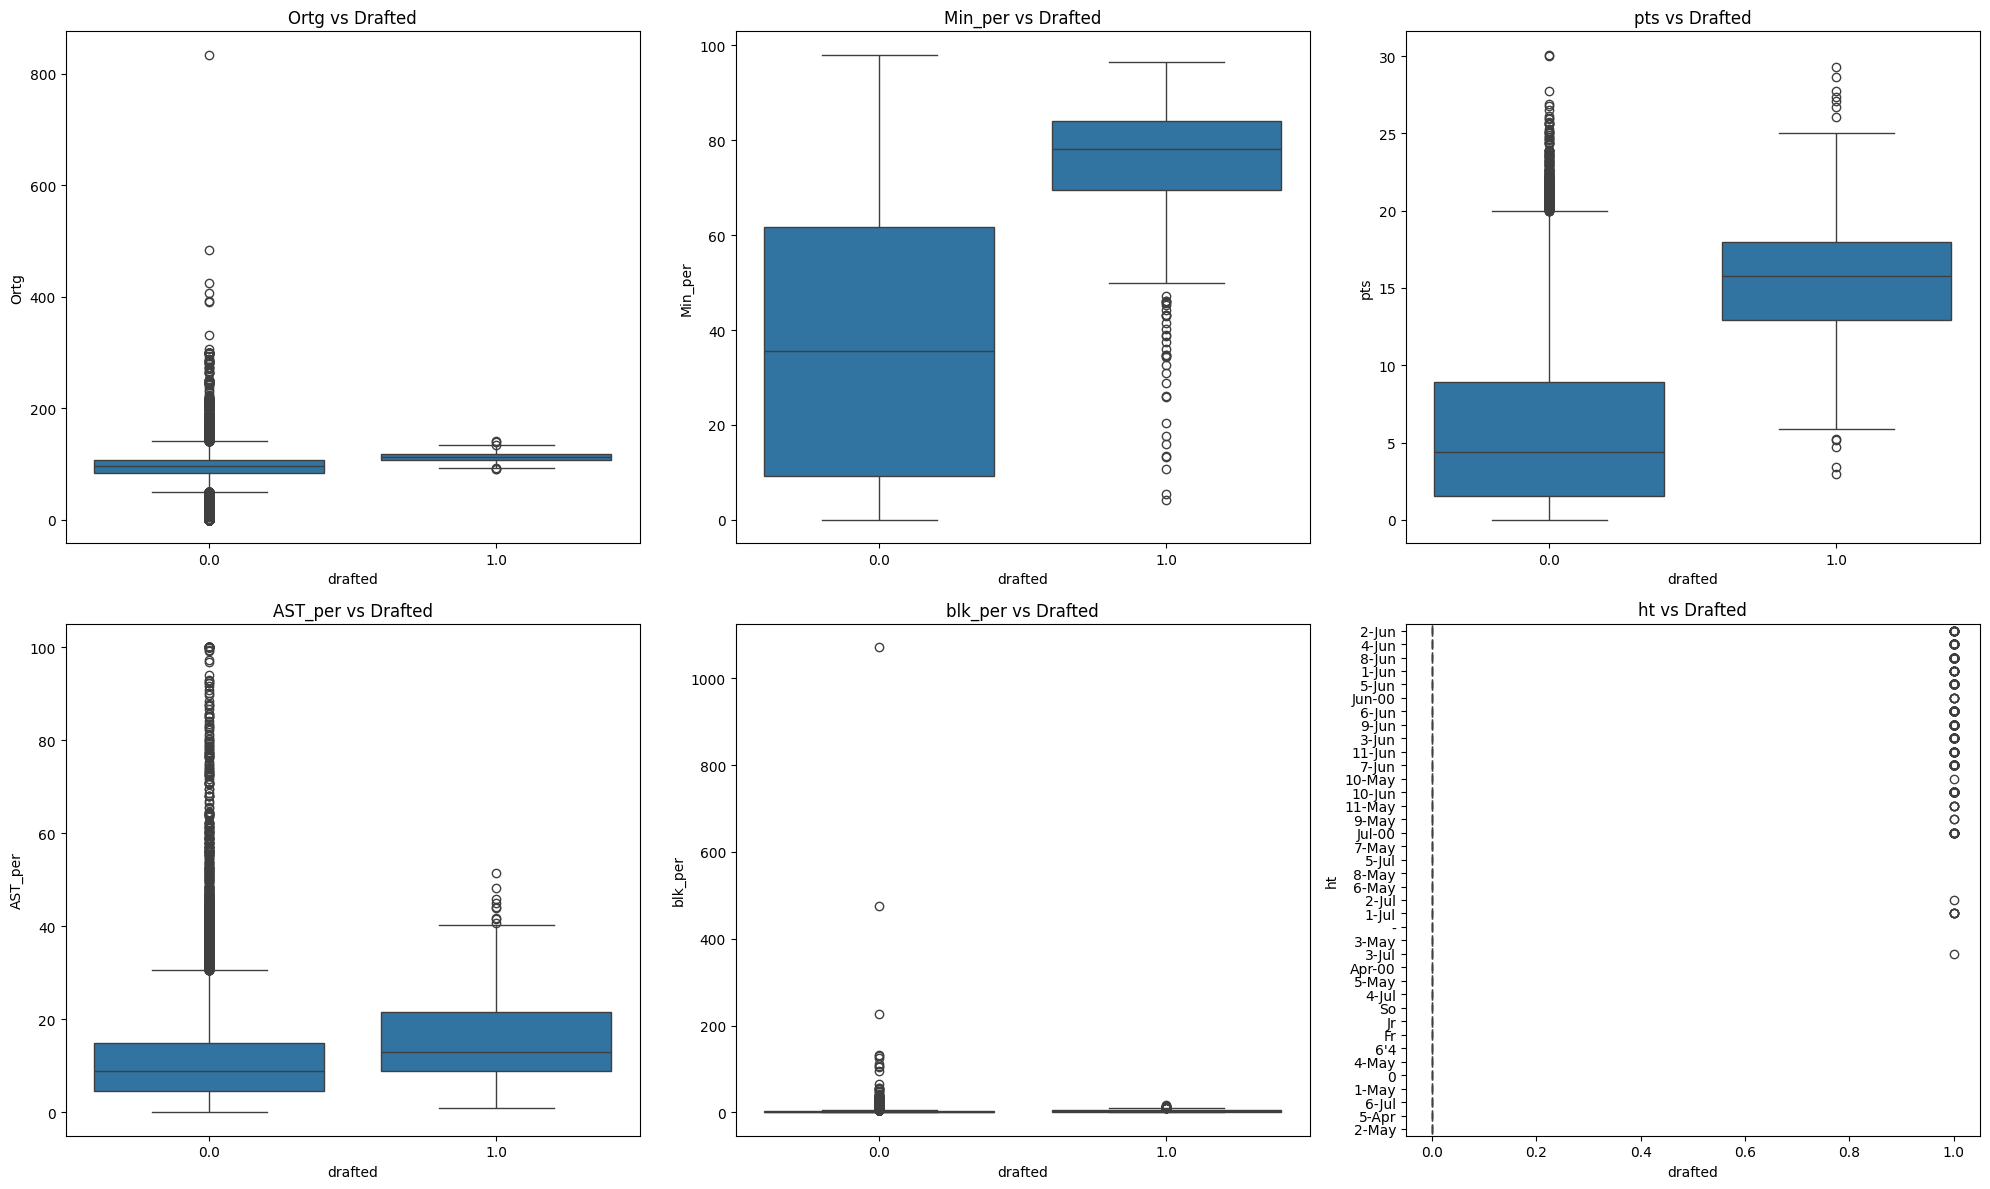

In [142]:
# 5. Relationship Between Key Features and Target (drafted)
key_features = ['Ortg', 'Min_per', 'pts', 'AST_per', 'blk_per', 'ht']

plt.figure(figsize=(20, 12))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='drafted', y=feature, data=df)
    plt.title(f'{feature} vs Drafted')
plt.tight_layout()
plt.show()


### 5. Prepare Data

In [68]:
df_cleaned = df.copy()
df_clean_test = test_df.copy()

In [69]:
df_cleaned = df_cleaned.drop(columns=['player_id', 'team', 'num', 'Rec_Rank', 'rimmade', 'rimmade_rimmiss', 'midmade', 'midmade_midmiss', 'rim_ratio', 'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'dunks_ratio', 'pick'])
df_clean_test = df_clean_test.drop(columns=['team', 'num', 'Rec_Rank', 'rimmade', 'rimmade_rimmiss', 'midmade', 'midmade_midmiss', 'rim_ratio', 'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'dunks_ratio', 'pick'])

In [70]:
print(df_cleaned.isnull().sum().sum(), df_clean_test.isnull().sum().sum())

4531 562


In [71]:
for column in df_clean_test.columns:
    if df_clean_test[column].dtype == 'object' or df_clean_test[column].dtype.name == 'category':
        # Fill categorical columns with mode
        df_clean_test[column].fillna(df_clean_test[column].mode()[0], inplace=True)
    else:
        # Fill numerical columns with mean
        df_clean_test[column].fillna(df_clean_test[column].mean(), inplace=True)

/var/folders/qz/l2xk6fnn5p399gdvg2snh00c0000gn/T/ipykernel_11149/472996061.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean_test[column].fillna(df_clean_test[column].mode()[0], inplace=True)
/var/folders/qz/l2xk6fnn5p399gdvg2snh00c0000gn/T/ipykernel_11149/472996061.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

In [72]:
print(df_cleaned.isnull().sum().sum(), df_clean_test.isnull().sum().sum())

4531 0


In [73]:
df_cleaned.dropna(inplace=True)

In [74]:
df_cleaned.shape

(43028, 50)

### 6. Split Dataset

In [75]:
target = 'drafted'

In [76]:
y = df_cleaned.pop(target)
X = df_cleaned

player_id_test = df_clean_test.pop('player_id')
X_test = df_clean_test

In [77]:
num_cols = list(X.select_dtypes('number').columns)
cat_cols = list(set(X.columns) - set(num_cols))

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
# X_train, X_val, y_train, y_val, player_id_train, player_id_val = train_test_split(X_data, y_data, player_id_data, stratify=y_data, random_state=42, test_size=0.2)

In [81]:
cat_cols

['ht', 'yr', 'type', 'conf']

In [82]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers = [
        ('ord', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

### 7. Baseline Model

In [45]:
from sklearn.pipeline import Pipeline

# Create a pipeline
model = Pipeline([
    ('preprocessing', preprocessor),
    ('model', xgb.XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    num_class=2,                # Number of classes in the target
    learning_rate=0.1,          # Step size shrinkage (common value)
    n_estimators=100,           # Number of boosting rounds (trees)
    max_depth=3,                # Maximum depth of a tree
    random_state=42
))
])

In [46]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ord', StandardScaler(),
                                                  ['GP', 'Min_per', 'Ortg',
                                                   'usg', 'eFG', 'TS_per',
                                                   'ORB_per', 'DRB_per',
                                                   'AST_per', 'TO_per', 'FTM',
                                                   'FTA', 'FT_per', 'twoPM',
                                                   'twoPA', 'twoP_per', 'TPM',
                                                   'TPA', 'TP_per', 'blk_per',
                                                   'stl_per', 'ftr', 'porpag',
                                                   'adjoe', 'pfr', 'year',
                                                   'ast_tov', 'drtg', 'adrtg',
                                                   'dporpag', ...]),
                                                 ('cat',
                                                  OneHo...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None, num_class=2,
                               num_parallel_tree=None, ...))])

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_train, y_pred_prob)

# Step 5: Print ROC AUC score
print(f'ROC AUC Score: {roc_auc}')

In [ ]:
y_pred_prob = pipeline.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_prob)

# Step 5: Print ROC AUC score
print(f'ROC AUC Score: {roc_auc}')

### 8. Train Machine Learning Model

In [59]:
!pip3 install imblearn

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imb_pipeline
from sklearn.linear_model import LogisticRegression


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [60]:
# Creating the pipeline with SMOTE and Logistic Regression
lr = imb_pipeline([
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression())
])

In [91]:
# Importing necessary libraries
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Creating the pipeline with SMOTE and Logistic Regression using imblearn's Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression())
])

# Fitting the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred_prob = pipeline.predict_proba(X_train)[:, 1]


ROC AUC Score: 0.992152580850412


/Users/rusanvaidya/Library/Caches/pypoetry/virtualenvs/36120amlaat1group6-QZhSvJqp-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 9. Assess Model Performance

In [47]:
y_train_preds = model.predict(X_train)

In [48]:
train_perf = classification_report(y_train, y_train_preds)
print(train_perf)

# model_valid_perf =
# model_test_perf =

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     34067
         1.0       0.87      0.44      0.58       355

    accuracy                           0.99     34422
   macro avg       0.93      0.72      0.79     34422
weighted avg       0.99      0.99      0.99     34422



In [90]:
from sklearn.metrics import roc_auc_score

y_pred_prob = model.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, y_pred_prob)

# Step 5: Print ROC AUC score
print(f'ROC AUC Score: {roc_auc}')

ROC AUC Score: 0.999902511910043


In [50]:
y_pred_val_prob = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_val_prob)

# Step 5: Print ROC AUC score
print(f'ROC AUC Score: {roc_auc}')

ROC AUC Score: 0.9829079448505501
